In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Layer
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import cv2

2025-09-28 04:03:38.056951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759032218.231548      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759032218.286248      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/nih-data/Data_Entry_2017.csv")

img_dir1 = "/kaggle/input/nih-data/images_001/images"
img_dir2 = "/kaggle/input/nih-data/images_002/images"

all_images_1 = os.listdir(img_dir1)
all_images_2 = os.listdir(img_dir2)
all_images = set(all_images_1 + all_images_2) 

df = df[df['Image Index'].isin(all_images)]

In [5]:
clean_df = df.drop([
    "Follow-up #", "OriginalImage[Width", "Height]",
    "OriginalImagePixelSpacing[x", "y]", "Unnamed: 11", "Patient ID"
], axis="columns")

clean_df.replace({"M": 1, "F": 0, "PA": 1, "AP": 0}, inplace=True)

all_labels = sorted(set(l for sublist in clean_df['Finding Labels'].str.split('|') for l in sublist))
for label in all_labels:
    clean_df[label] = clean_df['Finding Labels'].apply(lambda x: 1 if label in x.split('|') else 0)
clean_df = clean_df.drop(columns=['Finding Labels'])

/tmp/ipykernel_36/4202430426.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_df.replace({"M": 1, "F": 0, "PA": 1, "AP": 0}, inplace=True)


In [6]:
tabular_features = ['Patient Age', 'Patient Gender', 'View Position']
label_cols = clean_df.columns[4:]

train_df, temp_df = train_test_split(clean_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

scaler = MinMaxScaler()
train_tab = scaler.fit_transform(train_df[tabular_features])
val_tab = scaler.transform(val_df[tabular_features])
test_tab = scaler.transform(test_df[tabular_features])

y_train = train_df[label_cols].values
y_val = val_df[label_cols].values
y_test = test_df[label_cols].values

def get_full_image_path(filename, dir1, dir2):
    """Checks both directories and returns the full path for a given filename."""
    path1 = os.path.join(dir1, filename)
    if os.path.exists(path1):
        return path1
    path2 = os.path.join(dir2, filename)
    if os.path.exists(path2):
        return path2
    return None 

train_paths = [get_full_image_path(fname, img_dir1, img_dir2) for fname in train_df['Image Index']]
val_paths = [get_full_image_path(fname, img_dir1, img_dir2) for fname in val_df['Image Index']]
test_paths = [get_full_image_path(fname, img_dir1, img_dir2) for fname in test_df['Image Index']]


In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def process_image(filename, label, tab_features):
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return ({"image_input": img, "tab_input": tab_features}, label)

def create_dataset(paths, labels, tab_data):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels, tab_data))
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_paths, y_train, train_tab)
val_ds = create_dataset(val_paths, y_val, val_tab)
test_ds = create_dataset(test_paths, y_test, test_tab)


I0000 00:00:1759032466.014870      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
class FilmLayer(Layer):
    def __init__(self, **kwargs):
        super(FilmLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        image_shape, tab_shape = input_shape
        self.gamma_dense = Dense(image_shape[-1], activation='linear')
        self.beta_dense = Dense(image_shape[-1], activation='linear')
        super(FilmLayer, self).build(input_shape)

    def call(self, inputs):
        image_features, tab_features = inputs
        gamma = self.gamma_dense(tab_features)
        beta = self.beta_dense(tab_features)
        gamma = tf.expand_dims(tf.expand_dims(gamma, 1), 1)
        beta = tf.expand_dims(tf.expand_dims(beta, 1), 1)
        return image_features * gamma + beta

In [9]:
model = tf.keras.models.load_model('/kaggle/input/nih-data/densenet_model.h5', custom_objects={'FilmLayer': FilmLayer})

In [12]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(multi_label=True, name='auc')])


In [14]:
tf.config.run_functions_eagerly(True)
history = model.fit(
     train_ds,
     validation_data=val_ds,
     epochs=25, 
     callbacks=[
         tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=3, restore_best_weights=True)
     ]
)

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 374s 997ms/step - accuracy: 0.5840 - auc: 0.7553 - loss: 0.1777 - val_accuracy: 0.5780 - val_auc: 0.7309 - val_loss: 0.1793
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 373s 994ms/step - accuracy: 0.5965 - auc: 0.7791 - loss: 0.1710 - val_accuracy: 0.5733 - val_auc: 0.7292 - val_loss: 0.1825
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.6033 - auc: 0.8143 - loss: 0.1623 - val_accuracy: 0.5267 - val_auc: 0.7115 - val_loss: 0.1891
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.6184 - auc: 0.8414 - loss: 0.1512 - val_accuracy: 0.5280 - val_auc: 0.7047 - val_loss: 0.1959


In [15]:
print("\n--- AUC Performance ---")
y_pred_prob = model.predict(test_ds)
auc_scores = roc_auc_score(y_test, y_pred_prob, average=None)
auc_df = pd.DataFrame({'Label': label_cols, 'AUC': auc_scores})
print(auc_df)
total_auc_micro = roc_auc_score(y_test, y_pred_prob, average='micro')
print(f"\nTotal AUC (micro): {total_auc_micro:.4f}")
total_auc_macro = roc_auc_score(y_test, y_pred_prob, average='macro')
print(f"Total AUC (macro): {total_auc_macro:.4f}")


--- AUC Performance ---
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step
                 Label       AUC
0          Atelectasis  0.722827
1         Cardiomegaly  0.824436
2        Consolidation  0.731425
3                Edema  0.844004
4             Effusion  0.826860
5            Emphysema  0.824655
6             Fibrosis  0.659733
7               Hernia  0.918504
8         Infiltration  0.681546
9                 Mass  0.685697
10          No Finding  0.713255
11              Nodule  0.567803
12  Pleural_Thickening  0.686867
13           Pneumonia  0.621486
14        Pneumothorax  0.807858

Total AUC (micro): 0.8818
Total AUC (macro): 0.7411



--- Plotting Training History ---


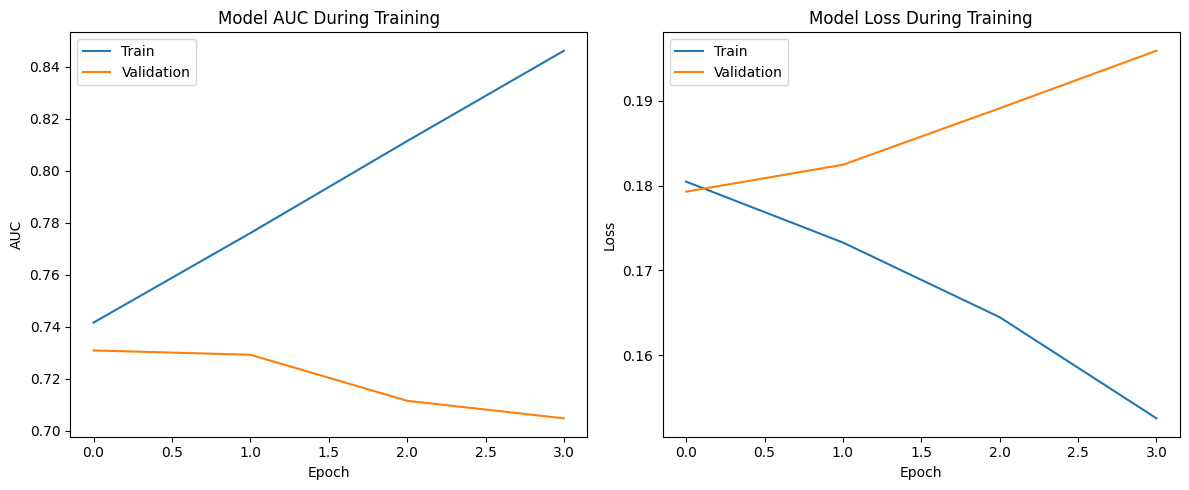


--- Generating Predictions for Evaluation ---
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 360ms/step

'No Finding' class at index 10 has been excluded from all following metrics.

--- Classification Report (Findings Only) ---
                    precision    recall  f1-score   support

       Atelectasis       1.00      0.01      0.02       131
      Cardiomegaly       0.00      0.00      0.00        31
     Consolidation       0.00      0.00      0.00        55
             Edema       0.00      0.00      0.00        24
          Effusion       0.54      0.11      0.18       132
         Emphysema       0.00      0.00      0.00        28
          Fibrosis       0.00      0.00      0.00        45
            Hernia       0.00      0.00      0.00         3
      Infiltration       0.33      0.01      0.02       242
              Mass       0.00      0.00      0.00        50
            Nodule       0.00      0.00      0.00        79
Pleural_Thickening       0.00      0.00      0.00        39
     

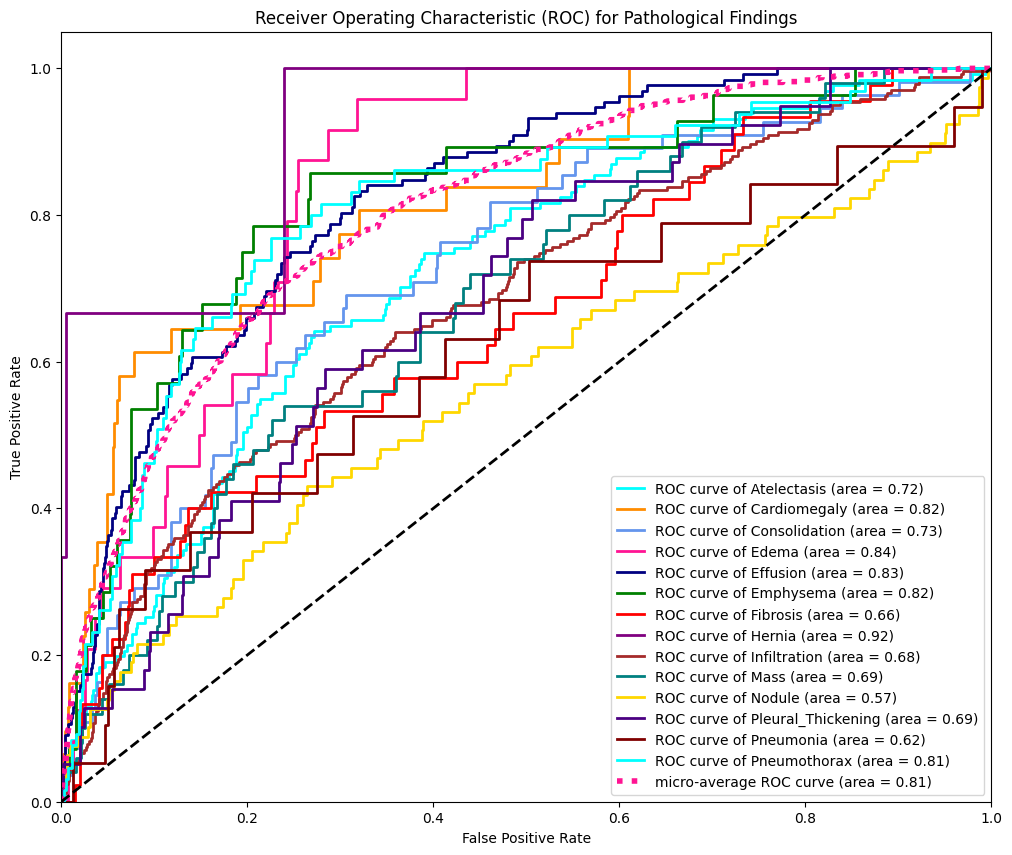


--- Generating Grad-CAM Visualizations for Findings ---
Displaying Grad-CAM for the most likely FINDING in each sample image:

--- Sample Image 10 ---


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['image_input', 'tab_input']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))', 'Tensor(shape=(1, 3))']
  warnings.warn(msg)


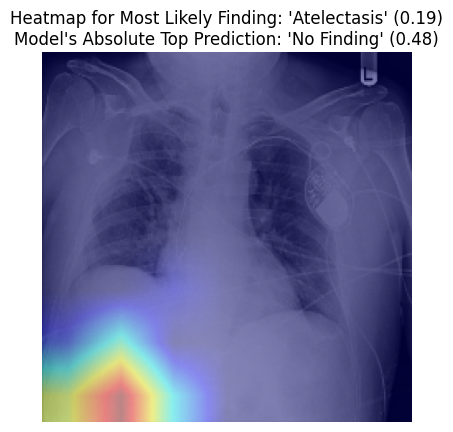


--- Sample Image 25 ---


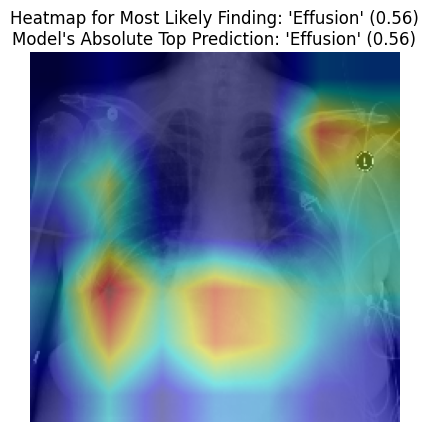


--- Sample Image 40 ---


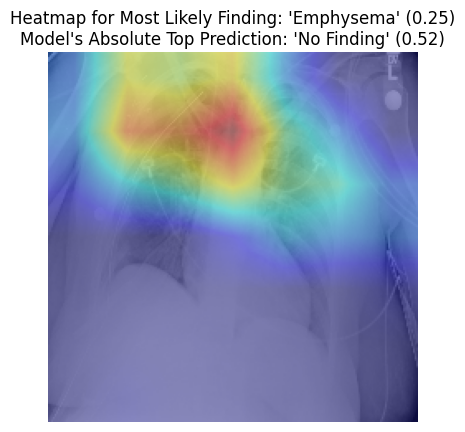

In [18]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC During Training')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss During Training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_history(history)

print("\n--- Generating Predictions for Evaluation ---")
y_pred_prob = model.predict(test_ds)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

if 'No Finding' in label_cols:
    no_finding_idx = list(label_cols).index('No Finding')
  
    eval_labels = [label for label in label_cols if label != 'No Finding']
    eval_y_test = np.delete(y_test, no_finding_idx, axis=1)
    eval_y_pred_prob = np.delete(y_pred_prob, no_finding_idx, axis=1)
    eval_y_pred_binary = np.delete(y_pred_binary, no_finding_idx, axis=1)
    
    print(f"\n'No Finding' class at index {no_finding_idx} has been excluded from all following metrics.")
else:
    # If 'No Finding' isn't present, just use the original variables
    eval_labels = label_cols
    eval_y_test = y_test
    eval_y_pred_prob = y_pred_prob
    eval_y_pred_binary = y_pred_binary

# b. Classification Report (on findings only)
from sklearn.metrics import classification_report

print("\n--- Classification Report (Findings Only) ---")
print(classification_report(eval_y_test, eval_y_pred_binary, target_names=eval_labels, zero_division=0))

from sklearn.metrics import roc_curve, auc
from itertools import cycle

print("\n--- Plotting ROC Curves (Findings Only) ---")
plt.figure(figsize=(12, 10))

fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(len(eval_labels)):
    fpr[i], tpr[i], _ = roc_curve(eval_y_test[:, i], eval_y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(eval_y_test.ravel(), eval_y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'navy', 'green', 'red', 'purple', 'brown', 'teal', 'gold', 'indigo', 'maroon'])
for i, color in zip(range(len(eval_labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {eval_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Pathological Findings')
plt.legend(loc="lower right")
plt.show()


print("\n--- Generating Grad-CAM Visualizations for Findings ---")

def get_grad_cam(model, img_array, tab_features, class_idx, layer_name='conv5_block16_concat'):
    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_array, tab_features])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-7)
    return heatmap.numpy(), predictions[0]


def display_finding_grad_cam(img_path, tab_features, model):
    img_array = np.expand_dims(img_to_array(load_img(img_path, target_size=IMG_SIZE)) / 255.0, axis=0)
    

    dummy_heatmap, predictions = get_grad_cam(model, img_array, tab_features, class_idx=0) # class_idx doesn't matter here
    
    preds_copy = predictions.numpy().copy()
    if 'No Finding' in label_cols:
        no_finding_idx = list(label_cols).index('No Finding')
        preds_copy[no_finding_idx] = -1.0 
  
    top_finding_idx = np.argmax(preds_copy)
    top_finding_label = label_cols[top_finding_idx]
    top_finding_score = predictions[top_finding_idx]
    
    actual_top_pred_idx = np.argmax(predictions)
    actual_top_pred_label = label_cols[actual_top_pred_idx]
    actual_top_pred_score = predictions[actual_top_pred_idx]

    heatmap, _ = get_grad_cam(model, img_array, tab_features, class_idx=top_finding_idx)

    img_orig = cv2.imread(img_path)
    img_orig = cv2.resize(img_orig, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap_resized = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

    title = (f"Heatmap for Most Likely Finding: '{top_finding_label}' ({top_finding_score:.2f})\n"
             f"Model's Absolute Top Prediction: '{actual_top_pred_label}' ({actual_top_pred_score:.2f})")

    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

print("Displaying Grad-CAM for the most likely FINDING in each sample image:")
for i in [10, 25, 40]:
    print(f"\n--- Sample Image {i} ---")
    display_finding_grad_cam(test_paths[i], np.expand_dims(test_tab[i], axis=0), model)